**Imports**

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torchvision import transforms
from dataloader_ViT import create_dataloaders
from transformer_model import ViT
from torch import nn
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
image_path = "/home/e183534/ERA_Datasets/pizza_steak_sushi"
train_dir = image_path + "/train"
test_dir = image_path + "/test"

# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


**Show a sample image**

(-0.5, 223.5, 223.5, -0.5)

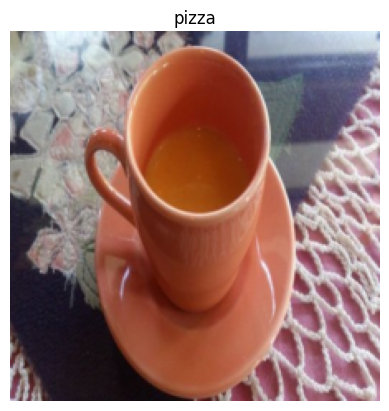

In [3]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)


**Pre process image into patches and create embeddings**

In [4]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}") 
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [5]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[-1.1725, -1.0583,  1.0068]], grad_fn=<AddmmBackward0>)

In [6]:
from torchinfo import summary

# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [7]:
from super_repo import data_setup, engine, utils
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=40,
                       device=device)

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.5637 | train_acc: 0.3594 | test_loss: 4.9385 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.8650 | train_acc: 0.4609 | test_loss: 3.0384 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.6985 | train_acc: 0.2734 | test_loss: 1.2668 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.1630 | train_acc: 0.2969 | test_loss: 1.3211 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1377 | train_acc: 0.4258 | test_loss: 1.2877 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2460 | train_acc: 0.3086 | test_loss: 1.1481 | test_acc: 0.1979
Epoch: 7 | train_loss: 1.1501 | train_acc: 0.2617 | test_loss: 1.0671 | test_acc: 0.2604
Epoch: 8 | train_loss: 1.1496 | train_acc: 0.3828 | test_loss: 1.5035 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1842 | train_acc: 0.4180 | test_loss: 1.1673 | test_acc: 0.2604
Epoch: 10 | train_loss: 1.1910 | train_acc: 0.2734 | test_loss: 1.1881 | test_acc: 0.1979
Epoch: 11 | train_loss: 1.2541 | train_acc: 0.2930 | test_loss: 1.0284 | test_acc: 0.5417
Epoch: 12 | train_l

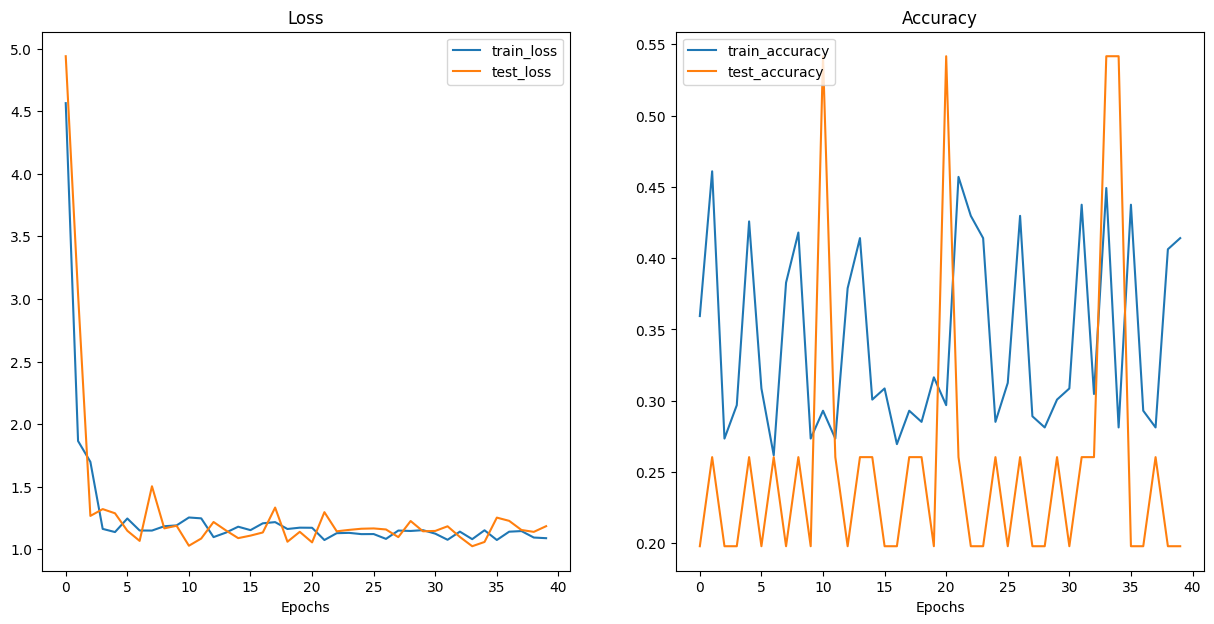

In [8]:
from super_repo.utils import plot_loss_curves

# Plot our ViT model's loss curves
plot_loss_curves(results)

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # requires torchvision >= 0.13, "DEFAULT" means best available

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output 

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=3,
                                      device=device)

In [ ]:
plot_loss_curves(pretrained_vit_results)

In [ ]:
# Save the model
utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/08_pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

In [ ]:
import requests

with open("download.jpeg", "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://www.boss-pizza.co.uk/site/assets/images/uploads/2_3_5c232a9d83be_o.jpg")
    print(f"Downloading...")
    f.write(request.content)

# Predict on custom image
utils.pred_and_plot_image(model=pretrained_vit,
                    image_path="download.jpeg",
                    transform=transforms.Resize((IMG_SIZE, IMG_SIZE)),
                    class_names=class_names)